In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:

import re

def parse_prediction(predicted_text_list,unit_list):

    pred_list=[]

    for i in range(len(predicted_text_list)):
        text=predicted_text_list[i]
        unit=unit_list[i]




        # 正規表現パターンを定義: "is" の後に数値部分 (-?(\d+(\.\d+)?))
        pattern = r"is\s*(-?\d+(\.\d+)?)"

        # 正規表現によるマッチング
        match = re.search(pattern, text)
        if match:
            predict=(match.group())
            #predict=predict.replace(unit,"").strip()
            #predict=predict.replace(unit[1:-1],"").strip()
            predict=predict.replace("is ","").strip()
            try:
                pred_val=float(predict)
            except:
                pred_val=None
        else:
            pred_val=None

        if pred_val is None:
            #正規表現で､「数値」 + unitを抽出｡数値は小数点やマイナスも含む｡unitの前にスペースがある場合もない場合もある
            unit_pattern = re.escape(unit).replace(r'\[', r'\[?').replace(r'\]', r'\]?')
            pattern = rf"-?\d+(\.\d+)?\s*{unit_pattern}"
            # 正規表現によるマッチング
            match = re.search(pattern, text)
            if match:
                predict=(match.group())
                predict=predict.replace(unit,"").strip()
                predict=predict.replace(unit[1:-1],"").strip()
                try:
                    pred_val=float(predict)
                except:
                    pred_val=None
        pred_list.append(pred_val)
    return pred_list

/tmp/ipykernel_1920850/418329140.py:48: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["predicted_value_float"][i]=predicted_value_list[i]
/tmp/ipykernel_1920850/418329140.py:48: SettingWithCopyWarning: 
A value is trying to be set on a co

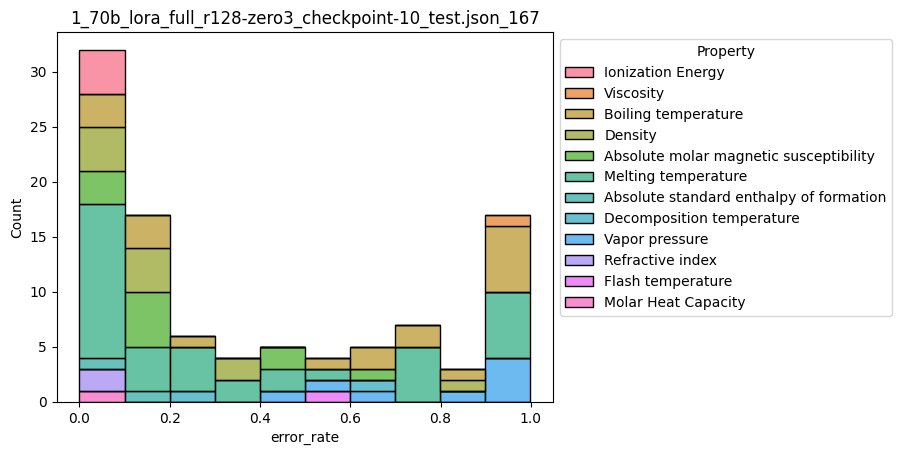

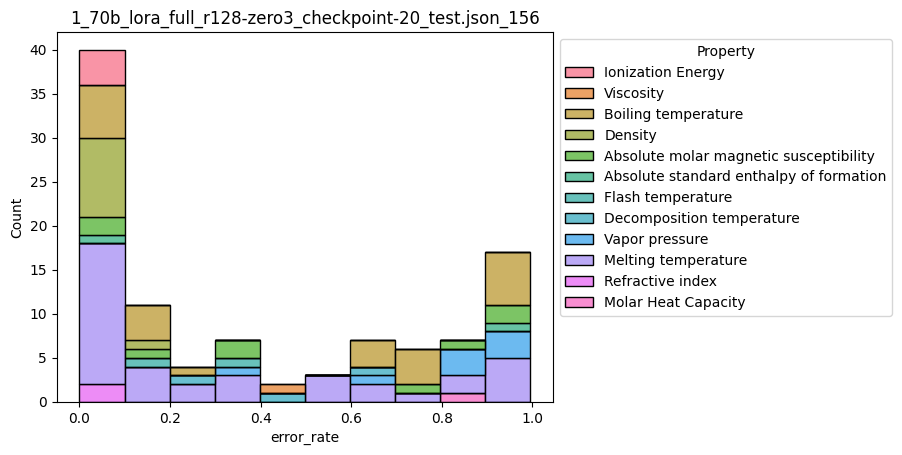

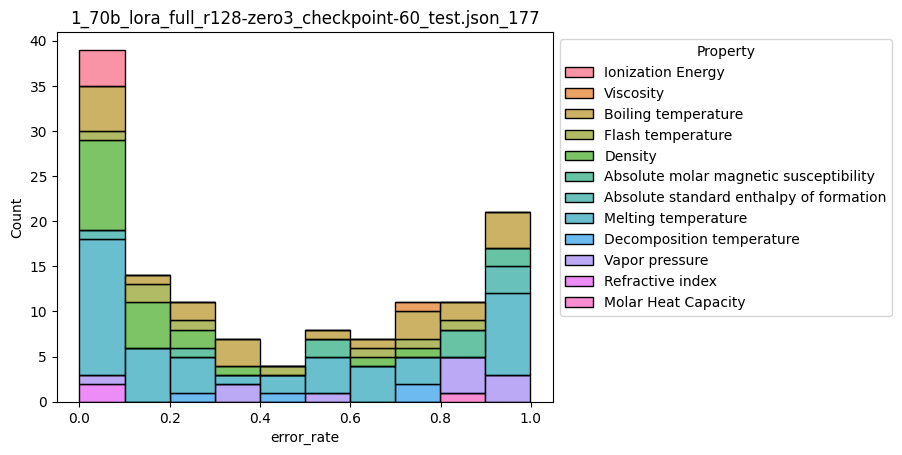

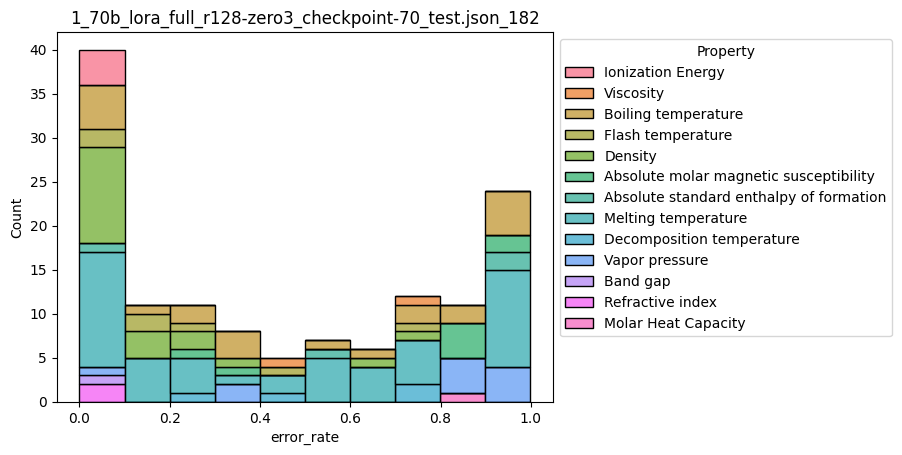

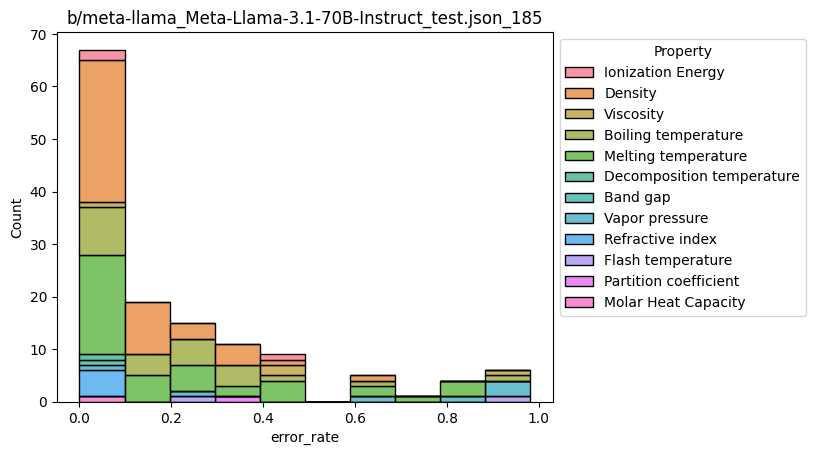

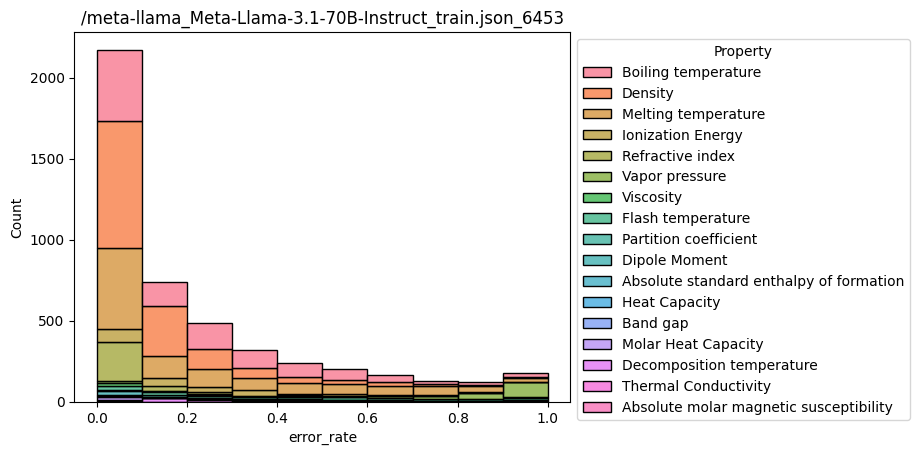

In [11]:
import glob
json_list=[]
#json_list+=glob.glob("eval_results2/*.json")
#json_list+=glob.glob("eval_results2/meta-llama_Meta-Llama-3.1-8B-Instruct_*.json") #original
#json_list+=glob.glob("eval_results_full/*.json")
#json_list+=glob.glob("eval_results_lora_llama/*.json")

#original train
#json_list+=glob.glob("/data/hatakeyama/self-loop/0920evaluate_prediction_accuracy/eval_results/*.json")

#original 70b
json_list+=glob.glob("eval_results_ori_70b/*.json")

#70b
json_list+=glob.glob("eval_results_lora_r128_70b/*.json")

#lora
if False:
    json_list+=glob.glob("eval_results_lora_r128/*.json")
    json_list+=glob.glob("eval_results_lora_r256/*.json")
    json_list+=glob.glob("eval_results_lora_r512/*.json")
    json_list+=glob.glob("eval_results_lora_r1024/*.json")
    json_list+=glob.glob("eval_results_lora_r2048/*.json")

mode="test"

error_rate_dict={}

json_list.sort()

for target_json in json_list:

    #if target_json.find(mode)==-1:
    #    continue

    df=pd.read_json(target_json)
    #predicted_valueをfloatに変更｡変換できないものはNaNにする
    df["predicted_value_float"] = pd.to_numeric(df["predicted_value"], errors='coerce')

    if target_json.find("meta")==-1:
        predicted_text_list=df["predicted_text"].tolist()
        unit_list=df["unit"].tolist()
        predicted_value_list=parse_prediction(predicted_text_list,unit_list)

        #df内がnanの場合は、predicted_value_listを代入
        for i in range(len(predicted_value_list)):
            if pd.isnull(df["predicted_value_float"][i]):
                df["predicted_value_float"][i]=predicted_value_list[i]
        #df["predicted_value_float"]=predicted_value_list


    #actual_value, predicted_valueの誤差率を計算(絶対値を取る
    df["error_rate"]=(df["Value"]-df["predicted_value_float"])/df["Value"]
    df["error_rate"]=df["error_rate"].abs()

    #誤差率が0以上のものを抽出
    sel_df=df[df["error_rate"]>=0]
    sel_df["predicted_text"].tolist()

    #plt.figure()
    #plt.title(target_json)
    #sns.boxplot(x="error_rate",y="Property",data=sel_df)
    #plt.xlim(-1,2)
    #xはlog
    #plt.xscale("log")
    #x=0.1に縦線を引く
    #plt.axvline(x=0.1, color='r', linestyle='--')

    plt.figure()
    plt.title(target_json[-50:]+"_"+str(sel_df.shape[0]))
    #sns.histplot(data=sel_df,x="error_rate",bins=100,hue="Property")
    ax=sns.histplot(data=sel_df[sel_df["error_rate"]<1],x="error_rate",
                 bins=10,hue="Property",
                multiple="stack"
                 )
    #plt.xlim(0,1)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    error_rate_dict[target_json]=sel_df["error_rate"].median()

In [12]:
error_rate_df=pd.DataFrame(error_rate_dict.items(),columns=["json","median_error_rate"])
error_rate_df["json"].to_list()

['eval_results_lora_r128_70b/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_70b_lora_llama_all_r128_1_output3_sftlab-experiments_70b_lora_llama_all_r128_1-llama3_1_70b_lora_full_r128-zero3_checkpoint-10_test.json',
 'eval_results_lora_r128_70b/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_70b_lora_llama_all_r128_1_output3_sftlab-experiments_70b_lora_llama_all_r128_1-llama3_1_70b_lora_full_r128-zero3_checkpoint-20_test.json',
 'eval_results_lora_r128_70b/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_70b_lora_llama_all_r128_1_output3_sftlab-experiments_70b_lora_llama_all_r128_1-llama3_1_70b_lora_full_r128-zero3_checkpoint-60_test.json',
 'eval_results_lora_r128_70b/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_70b_lora_llama_all_r128_1_output3_sftlab-experiments_70b_lora_llama_all_r128_1-llama3_1_70b_lora_full_r128-zero3_checkpoint-70_test.json',
 'eval_results_ori_70b/meta-llama_Meta-Llama-3.1-70B-Instruc

<Axes: xlabel='step', ylabel='median_error_rate'>

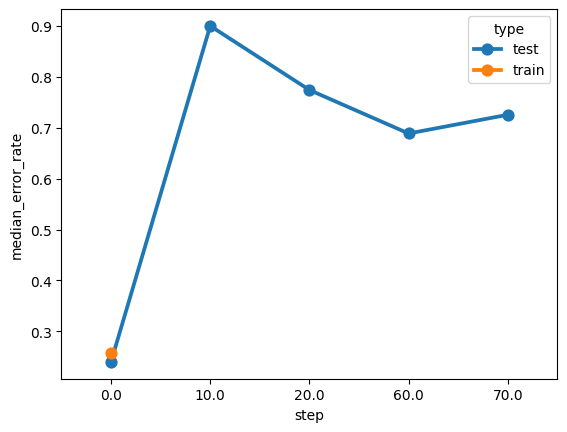

In [13]:
error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["step"] = error_rate_df["step"].fillna(0)
#error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
error_rate_df["type"]=error_rate_df["json"].str.split("_").str[-1].str.split(".").str[0]
sns.pointplot(data=error_rate_df,x="step",y="median_error_rate",hue="type")

In [14]:
#合成された物性データの数
tot_augment_records=1398000*2.5
print("合成された物性データの合計",tot_augment_records)

#元の物性データの数
tot_original_records=7000

#ひとつの物性データがデータベースの中に何回出現するか
total_records_per_property=tot_augment_records/tot_original_records

#今回の学習で使う物性データの数
trained_augment_records=200000
trained_records_per_property=total_records_per_property*trained_augment_records/tot_augment_records
print("今回の学習全体で､特定のpropertyを平均で何回学習するか",trained_records_per_property)

tot_steps=97
seen_times_per_step=trained_records_per_property/tot_steps
print("1stepあたり､特定のpropertyを平均で何回学習するか",seen_times_per_step)

合成された物性データの合計 3495000.0
今回の学習全体で､特定のpropertyを平均で何回学習するか 28.57142857142857
1stepあたり､特定のpropertyを平均で何回学習するか 0.2945508100147275


<Axes: xlabel='Average seen times', ylabel='median_error_rate'>

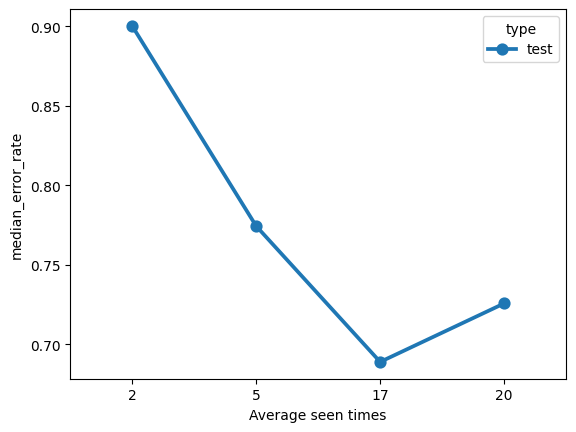

In [15]:

error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["step"] = error_rate_df["step"].fillna(0)
#error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
error_rate_df["type"]=error_rate_df["json"].str.split("_").str[-1].str.split(".").str[0]
error_rate_df["Average seen times"]=(seen_times_per_step*error_rate_df["step"]).astype(int)
sns.pointplot(data=error_rate_df[error_rate_df["json"].str.find("70B")==-1],x="Average seen times",y="median_error_rate",hue="type")

In [16]:
error_rate_df


,json,median_error_rate,temp,step,type,Average seen times
0,eval_results_lora_r128_70b/_data_hatakeyama_se...,0.900293,10_test,10.0,test,2
1,eval_results_lora_r128_70b/_data_hatakeyama_se...,0.774315,20_test,20.0,test,5
2,eval_results_lora_r128_70b/_data_hatakeyama_se...,0.688810,60_test,60.0,test,17
3,eval_results_lora_r128_70b/_data_hatakeyama_se...,0.725636,70_test,70.0,test,20
4,eval_results_ori_70b/meta-llama_Meta-Llama-3.1...,0.239651,eval_results_ori_70b/meta-llama_Meta-Llama-3,0.0,test,0
5,eval_results_ori_70b/meta-llama_Meta-Llama-3.1...,0.258059,eval_results_ori_70b/meta-llama_Meta-Llama-3,0.0,train,0


In [17]:
error_rate_df["lora_r"]=(error_rate_df["json"].str.split("lora_r").str[1].str.split("/").str[0]).astype(int)
error_rate_df

sns.pointplot(data=error_rate_df,x="lora_r",y="median_error_rate",hue="type")

ValueError: invalid literal for int() with base 10: '128_70b'

In [ ]:

error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
sns.scatterplot(data=error_rate_df[error_rate_df["type"]=="train"],x="step",y="median_error_rate",hue="type")

: 

: 

In [ ]:
t="sftlab/experiments/test/1/output3/1-llama3_1_8b_3-zero1/checkpoint-60"
len(t)

: 

: 

: 

: 